In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import sys
import numpy             as np
import pylab             as pl
import astropy.io.fits   as fits
import matplotlib.pyplot as plt

from   astropy.table     import Table

In [3]:
sys.path.append('/global/homes/m/mjwilson/desi/BGS/Sam/')
sys.path.append('/global/homes/m/mjwilson/desi/BGS/Sam/DESI/')

In [4]:
from   cosmo         import distmod, cosmo
from   gama_limits   import gama_field
from   cartesian     import cartesian, rotate
from   findfile      import findfile, write_desitable

In [5]:
path       = "/project/projectdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/BGS/z0.200/"

f          = h5py.File(path+"cutsky_BGS_z0.200_AbacusSummit_base_c000_ph000.hdf5", "r")

stat       = f["Data/STATUS"]           #  integer indicating the status of the galaxy. If the second bit is 1, the galaxy is in the full DESI footprint. If the third bit is 1, the galaxy is in the SV3 footprint.
Ms         = f["Data/abs_mag"]
rs         = f["Data/app_mag"]
ra         = f["Data/ra"]
dec        = f["Data/dec"]
rest_color = f["Data/g_r"]
color      = f["Data/g_r_obs"]
hmass      = f["Data/halo_mass"]
gtype      = f["Data/galaxy_type"][...] # galaxy type, indicating cen/sat and if resolved
zcos       = f["Data/z_cos"][...] 
zobs       = f["Data/z_obs"][...]       # observed redshift (which takes into account velocity)

In [6]:
in_gama    = gama_field(ra[:], dec[:]) != 'NAN'
in_sv3     = stat[:] & 2**2 != 0        # in SV3 footprint

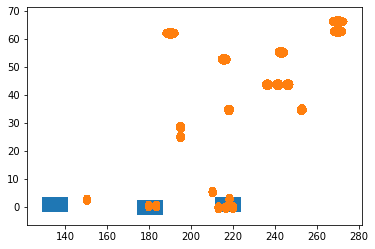

In [7]:
pl.plot(ra[in_gama], dec[in_gama], marker=',', lw=0.)
pl.plot(ra[in_sv3],  dec[in_sv3],  marker=',', lw=0.)

In [8]:
abacus_gold = Table(np.c_[ra[in_gama], dec[in_gama], zobs[in_gama], color[in_gama], rs[in_gama]], names=['RA', 'DEC', 'ZSURV', 'GMR', 'DETMAG'])
abacus_gold

RA,DEC,ZSURV,GMR,DETMAG
float64,float64,float64,float64,float64
221.5885153152424,0.8891047057315121,0.5090892329901424,1.0229034342276404,20.024842282773086
220.8388953469847,-0.4251537922799557,0.5070480777796309,1.7105688681513556,19.628412712111086
220.94292732616822,-0.4270795124586044,0.49939175793283663,1.7845642480200117,19.901759754751843
220.7779893960335,-0.407688561440169,0.5018416604587173,1.4162324622458227,19.482987811542994
220.80226411916357,-0.4094482845217407,0.5057908251547902,1.2950170504420262,20.188566388984835
220.70390645849213,-0.6597925197195444,0.5014725673267042,1.6087622340475303,20.1247197763516
220.22826508916,1.0077602929401275,0.49551292879741426,0.7722403108060668,20.153584782309252
220.18913734445744,-0.2921131117892873,0.4983282691011963,1.7167553284832642,19.979288042865907
219.94042101710016,-0.7595276462233099,0.49658973340918866,1.5065223264925345,19.715868889241545


In [9]:
abacus_gold['LUMDIST']      = cosmo.luminosity_distance(abacus_gold['ZSURV'].data)
abacus_gold['DISTMOD']      = distmod(abacus_gold['ZSURV'].data)
abacus_gold['FIELD']        = gama_field(abacus_gold['RA'], abacus_gold['DEC'])
abacus_gold['IN_D8LUMFN']   = np.zeros_like(abacus_gold['FIELD'], dtype=int)
abacus_gold['CONSERVATIVE'] = np.zeros_like(abacus_gold['FIELD'], dtype=int)

In [10]:
xyz                         = cartesian(abacus_gold['RA'], abacus_gold['DEC'], abacus_gold['ZSURV'])

In [11]:
abacus_gold['CARTESIAN_X']  = xyz[:,0]
abacus_gold['CARTESIAN_Y']  = xyz[:,1]
abacus_gold['CARTESIAN_Z']  = xyz[:,2]

In [12]:
xyz                         = rotate(abacus_gold['RA'], abacus_gold['DEC'], xyz)

In [13]:
abacus_gold['ROTCARTESIAN_X'] = xyz[:,0]
abacus_gold['ROTCARTESIAN_Y'] = xyz[:,1]
abacus_gold['ROTCARTESIAN_Z'] = xyz[:,2]

In [14]:
abacus_gold

RA,DEC,ZSURV,GMR,DETMAG,LUMDIST,DISTMOD,FIELD,IN_D8LUMFN,CONSERVATIVE,CARTESIAN_X,CARTESIAN_Y,CARTESIAN_Z,ROTCARTESIAN_X,ROTCARTESIAN_Y,ROTCARTESIAN_Z
,,,,,Mpc,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,str3,int64,int64,float64,float64,float64,float64,float64,float64
221.5885153152424,0.8891047057315121,0.5090892329901424,1.0229034342276404,20.024842282773086,2063.3533641152785,41.57286805199301,G15,0,0,-1022.5110811033369,-907.4613657201679,21.216392261730327,1021.7012266085815,908.4394319792988,18.15429773025413
220.8388953469847,-0.4251537922799557,0.5070480777796309,1.7105688681513556,19.628412712111086,2053.2891999806543,41.562250614145434,G15,0,0,-1030.7407448849524,-890.9333243854388,-10.109797455218517,1029.852777125875,891.9192735066924,-13.196464089950581
220.94292732616822,-0.4270795124586044,0.49939175793283663,1.7845642480200117,19.901759754751843,2015.6444390073257,41.5220696235003,G15,0,0,-1015.4119768436542,-880.9099247810838,-10.020303818676183,1014.5339449244166,881.8812097804043,-13.061057243623502
220.7779893960335,-0.407688561440169,0.5018416604587173,1.4162324622458227,19.482987811542994,2027.6719718440368,41.5349884901389,G15,0,0,-1022.3498876709572,-881.7836115364541,-9.606734318608583,1021.4722248754321,882.7615353001427,-12.668280938154894
220.80226411916357,-0.4094482845217407,0.5057908251547902,1.2950170504420262,20.188566388984835,2047.096049668563,41.55569110110545,G15,0,0,-1029.0600367079237,-888.3317613425351,-9.715078196618744,1028.1757498224451,889.3161033180729,-12.796716759406744
220.70390645849213,-0.6597925197195444,0.5014725673267042,1.6087622340475303,20.1247197763516,2025.8588505418343,41.53304591547108,G15,0,0,-1022.783423939799,-879.8538632994431,-15.536991846772187,1021.8898318637006,880.8322028148979,-18.599816731667264
220.22826508916,1.0077602929401275,0.49551292879741426,0.7722403108060668,20.153584782309252,1996.6369296550938,41.50149549765658,G15,0,0,-1019.1497456392286,-862.1104775579664,23.481246361605102,1018.3900937372865,863.0853479854154,20.42908595795937
220.18913734445744,-0.2921131117892873,0.4983282691011963,1.7167553284832642,19.979288042865907,2010.428704727106,41.516443382239125,G15,0,0,-1024.9980089272194,-865.8574228999394,-6.840821215061037,1024.143863177716,866.8378880488672,-9.91036270716756


In [15]:
# 
abacus_gold.meta['RMAX'] = 12.0
abacus_gold.meta['RLIM'] = 19.8

isin        = (abacus_gold.meta['RMAX'] <= abacus_gold['DETMAG']) & (abacus_gold['DETMAG'] <= abacus_gold.meta['RLIM'])
abacus_gold = abacus_gold[isin]

In [16]:
# Randomise rows.                                                                                                                                                                                       
idx  = np.arange(len(abacus_gold))
idx  = np.random.choice(idx, size=len(idx), replace=False)

abacus_gold = abacus_gold[idx]

In [17]:
abacus_gold

RA,DEC,ZSURV,GMR,DETMAG,LUMDIST,DISTMOD,FIELD,IN_D8LUMFN,CONSERVATIVE,CARTESIAN_X,CARTESIAN_Y,CARTESIAN_Z,ROTCARTESIAN_X,ROTCARTESIAN_Y,ROTCARTESIAN_Z
,,,,,Mpc,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,str3,int64,int64,float64,float64,float64,float64,float64,float64
174.37420413726636,-2.0519345988747837,0.3359304329984998,1.7056969977288279,19.123922215709594,1254.503238661886,40.49235893419643,G12,0,0,-933.926040517658,91.99678485174377,-33.62296324712214,933.9086807157997,-91.10303154242742,-36.42217682976647
220.4029804185612,2.3362116784059266,0.15383787141569427,0.8641938382476889,19.20470210886393,516.183517345691,38.56402066318472,G15,0,0,-340.3852624213592,-289.72109744263673,18.235956779016316,340.16098891257684,290.04669306252765,17.216525845216935
217.6679708597847,2.2037267013979567,0.30158433036949694,1.2794250535298946,19.15142502476224,1105.7533551397148,40.21829132902328,G15,0,0,-671.9722913409249,-518.7594321093857,32.6673549673255,671.5704545965309,519.4022317522295,30.654705622434467
215.89111219476248,2.936762329539373,0.3386299013461347,1.2941076944292682,18.66940304350552,1266.36900612549,40.51280136400385,G15,0,0,-765.3941103445783,-553.8720120326834,48.468071514980885,765.0055676216251,554.6041946742858,46.175454272635776
132.02237181435433,1.7744245887461325,0.20563021394553882,0.7948749033398567,19.200868334951373,713.1201790555166,39.26581362894001,G9,0,0,-395.7668865588467,439.1986660057935,18.315302335220984,396.2401061069655,-438.819739745951,17.12779434189897
223.28297887147755,-0.4890905464065565,0.24816422834936702,1.3752950346229174,18.86673842725752,882.8617283376807,39.72946345377576,G15,0,0,-514.8995055743692,-484.9280293208565,-6.037850016011829,514.4148159968636,485.4205352220764,-7.579654489531594
220.12120846787516,0.24089658458052188,0.24791416857937287,0.5931106987271441,19.22874232184933,881.8433972216435,39.72695733744431,G15,0,0,-540.3613821382736,-455.3684933012079,2.971074093850205,539.9318540760615,455.88537822497744,1.3528317428196632
134.14388223772949,-0.2508490889524511,0.2542422617408704,1.1484203728804896,19.68925507176145,907.6865714039614,39.789679552029824,G9,0,0,-504.02040186823325,519.3122519025678,-3.168421768123375,504.50535957749986,-518.8296968421948,-4.680513245949569


In [21]:
abacus_gold.meta['GOLD_NGAL'] = len(abacus_gold)
abacus_gold.meta['IMMUTABLE'] = 'FALSE'
abacus_gold.meta['AREA']      = 180.

In [22]:
opath = findfile(ftype='gold', dryrun=False, survey='abacus_gama')
opath

'/global/cscratch1/sd/mjwilson/norberg/GAMA4/abacus_gama_gold.fits'

In [23]:
write_desitable(opath, abacus_gold)




chgrp desi /global/cscratch1/sd/mjwilson/norberg/GAMA4/abacus_gama_gold.fits b''
chmod  700 /global/cscratch1/sd/mjwilson/norberg/GAMA4/abacus_gama_gold.fits b''


# Done.